## Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

## Set Option

In [ ]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Read Data

In [ ]:
#df_final = pd.read_csv("/content/drive/MyDrive/Internship/Main Project/Dataset/Final Data.csv")
df_loan = pd.read_csv('LoanExport.csv')

## User defined function

In [ ]:
# Function for replace the Not Available values to "nan"
def feature_nan(df):
  df.replace('X', np.NaN, inplace = True)
  #df.replace('X ', np.nan, inplace = True) # For feature PropertyType the 'X ' is having a space.
  #df.replace('X    ', np.nan, inplace = True) # # For feature MSA the 'X ' is having a space.
  df['CreditScore'].replace( 0, np.NaN, inplace = True)
  df['LTV'].replace( 0, np.NaN, inplace = True)
  df['Units'].replace( 0, np.NaN, inplace = True)
  return(df)

In [ ]:
# Function for converting MSA feature to [1,0]
def feature_msa(df):
  df['MSA'].iloc[df['MSA'].notnull()] = 1
  df['MSA'].fillna(0, inplace = True)
  df['MSA'] = df['MSA'].astype('category')
  return(df)

In [ ]:
# Function for correct the data type of features
def feature_dtype(df):
  df['MSA'] = df['MSA'].astype('object')
  df['Units'] = df['Units'].astype('object')
  df['EverDelinquent'] = df['EverDelinquent'].astype('object')
  return(df)

In [ ]:
# Function for strip the column values
def feature_strip(df):
  cols = df.select_dtypes(object).columns
  df[cols] = df[cols].apply(lambda x: x.str.strip())
  return(df)

In [ ]:
# Function for drop the unwanted columns
def feature_drop(df):
  df.drop(columns = ['OCLTV', 'PropertyState', 'PostalCode', 'LoanSeqNum', 'SellerName', 'ServicerName', 'MonthsDelinquent', 'FirstPaymentDate', 'MaturityDate', 'ProductType'],axis = 1, inplace = True)
  return(df)

## Preprocessing the data

In [ ]:
df_loan.shape

(41355, 28)

In [ ]:
df_process = df_loan.copy()

In [ ]:
df_process= feature_strip(df_process)

### Replace the Not applicable values using NaN

In [ ]:
df_loan.columns

Index(['CreditScore', 'FirstPaymentDate', 'FirstTimeHomebuyer', 'MaturityDate',
       'MSA', 'MIP', 'Units', 'Occupancy', 'OCLTV', 'DTI', 'OrigUPB', 'LTV',
       'OrigInterestRate', 'Channel', 'PPM', 'ProductType', 'PropertyState',
       'PropertyType', 'PostalCode', 'LoanSeqNum', 'LoanPurpose',
       'OrigLoanTerm', 'NumBorrowers', 'SellerName', 'ServicerName',
       'EverDelinquent', 'MonthsDelinquent', 'MonthsInRepayment'],
      dtype='object')

In [ ]:
# Call function for replace the Not Avaliable values with "nan"
df_process = feature_nan(df_process)

In [ ]:
# Percentage of missing values
# df_process.isnull().sum() * 100/ df_process.isnull().count()

When we check earlier null value is present only on feature "SellerName". 

In [ ]:
df_process.isnull().sum()

CreditScore            1189
FirstPaymentDate          0
FirstTimeHomebuyer    10789
MaturityDate              0
MSA                    5811
MIP                       0
Units                     0
Occupancy                 0
OCLTV                     0
DTI                       0
OrigUPB                   0
LTV                       1
OrigInterestRate          0
Channel                   0
PPM                     803
ProductType               0
PropertyState             0
PropertyType              0
PostalCode             8588
LoanSeqNum                1
LoanPurpose               1
OrigLoanTerm              1
NumBorrowers             56
SellerName             3418
ServicerName              1
EverDelinquent            1
MonthsDelinquent          1
MonthsInRepayment         1
dtype: int64

We are going to delete the null values of **PropertyType, Units and LTV**, since the null value rows are very less.

In [ ]:
# Dropping null value columns

df_process.dropna(subset = ['PropertyType', 'Units', 'LTV'], inplace = True)

In [ ]:
df_process.shape

(41354, 28)

The feature **OCLTV** has to be deleted since it is highly correlated with feature LTV. We can delete either **EverDelinquent, MonthsDelinquent** since MonthsDelinquent has values only if EverDelinquent is 1. Here we are deleting **MonthsDelinquent**. 

In [ ]:
#df_process[['EverDelinquent', 'MonthsDelinquent']][df_process['EverDelinquent'] == 0].shape

In [ ]:
# Call the function for convert the non null values of MSA to 1 and nan to 0
df_process = feature_msa(df_process)

## Convert the features to correct datatypes

In [ ]:
df_process = feature_dtype(df_process)

In [ ]:
# Calling function for deleting unwanted columns
df_process = feature_drop(df_process)

In [ ]:
df_process.select_dtypes(include=['object']).columns

Index(['FirstTimeHomebuyer', 'MSA', 'Units', 'Occupancy', 'Channel', 'PPM',
       'PropertyType', 'LoanPurpose', 'NumBorrowers', 'EverDelinquent'],
      dtype='object')

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
original = df_process
mask = df_process.isnull()
df_process = df_process.astype(str).apply(label_encoder.fit_transform).where(~mask, original)

In [ ]:
# Standard scalling
scale= StandardScaler()
df_scaled = scale.fit_transform(df_process)

In [ ]:
df_process = pd.DataFrame(df_scaled,columns = df_process.columns)

In [ ]:
# Split dataset into Null and Non Null datasets
df_notnull = df_process[df_process.isnull().any(axis=1) == False] # Train and Validation
df_null = df_process[df_process.isnull().any(axis=1) == True]

In [ ]:
df_null.shape

(12475, 18)

In [ ]:
84028+207394

291422

## KNN

In [ ]:
imputer = KNNImputer()
imputer.fit(df_notnull)

KNNImputer()

In [ ]:
df_imputed = imputer.fit_transform(df_null) # Near 7 min

In [ ]:
df_processed = pd.DataFrame(df_imputed,columns = df_process.columns)

In [ ]:
df_processed.shape

(12475, 18)

In [ ]:
result = df_notnull.append(df_processed)

In [ ]:
# Sort with index
result.sort_index(axis = 0, inplace = True)

In [ ]:
result.shape

(41354, 18)

In [ ]:
df_final = result.copy()

## PCA

In [ ]:
pca = PCA(n_components = 18)
df_pca = pca.fit_transform(df_final)

In [ ]:
df_pca.shape

(291422, 18)

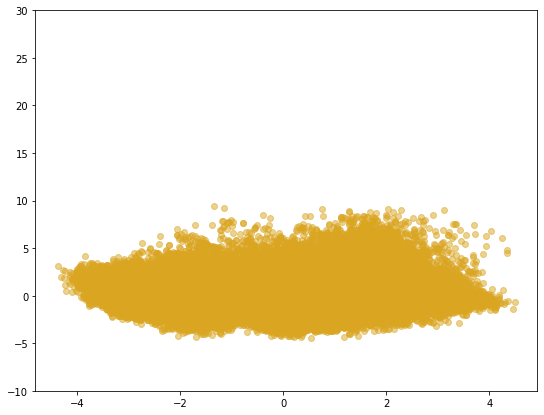

In [ ]:
plt.figure(figsize = (9,7))
plt.scatter(df_pca[:,0],df_pca[:,1], c='goldenrod',alpha=0.5)
plt.ylim(-10,30)
plt.show()

https://www.kaggle.com/code/sanikamal/principal-component-analysis-with-kmeans/notebook

## VISUALISATIONS WITH KMEANS CLUSTERING

In [ ]:
kmeans = KMeans(n_clusters=2)
X_clustered = kmeans.fit_predict(df_pca)

In [ ]:
# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

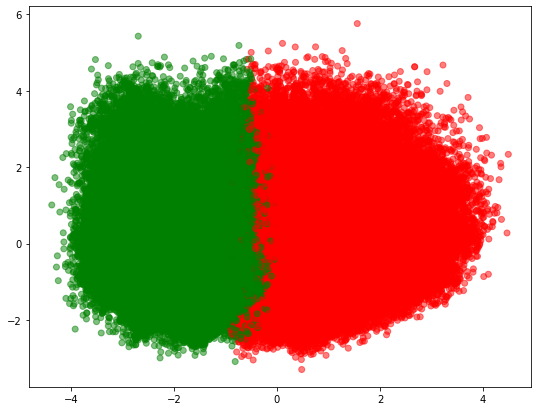

In [ ]:
# Plot the scatter digram
plt.figure(figsize = (9,7))
plt.scatter(df_pca[:,0],df_pca[:,2], c= label_color, alpha=0.5) 
plt.show()

In [ ]:
X_clustered
#X_clustered = pd.DataFrame(X_clustered, columns=['Clustered'])
X_clustered = pd.Series(X_clustered, name="Clustered")

In [ ]:
X_clustered.value_counts()

0    191499
1     99923
Name: Clustered, dtype: int64

In [ ]:
df_final.reset_index(inplace=True, drop=True)

In [ ]:
df_data = pd.concat([df_final,X_clustered], axis = 1)

In [ ]:
df_data

,CreditScore,FirstTimeHomebuyer,MSA,MIP,Units,Occupancy,DTI,OrigUPB,LTV,OrigInterestRate,Channel,PPM,PropertyType,LoanPurpose,OrigLoanTerm,NumBorrowers,EverDelinquent,MonthsInRepayment,Clustered
0,-0.000824,-0.398747,0.393627,1.192364,-0.12803,0.032122,-0.360176,-1.027657,0.766443,-0.637045,0.853110,-0.117896,0.336973,1.025459,0.071988,0.744245,-0.496634,0.540202,1
1,0.599775,-0.398747,0.393627,-0.696962,-0.12803,0.032122,-1.171754,-1.091345,-0.266998,-1.062556,-1.144198,-0.117896,0.336973,-0.296631,0.071988,-1.343643,-0.496634,-1.949629,0
2,0.264376,-0.398747,0.393627,-0.696962,-0.12803,0.032122,-1.245534,1.399589,-0.145417,-0.424289,0.853110,-0.117896,0.336973,-0.296631,0.071988,0.744245,-0.496634,0.902359,0
3,0.467175,-0.398747,0.393627,-0.696962,-0.12803,0.032122,-1.393094,-0.687984,-0.084626,-0.424289,-1.144198,-0.117896,0.336973,-0.296631,0.071988,0.744245,-0.496634,0.110140,0
4,-0.445424,-0.398747,0.393627,-0.696962,-0.12803,0.032122,-1.097974,-1.091345,0.036955,0.710407,-1.144198,-0.117896,0.336973,-0.296631,0.071988,0.744245,-0.496634,0.585472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291417,2.343073,-0.398747,0.393627,-0.696962,-0.12803,0.032122,0.082503,1.420818,-1.118068,0.095780,-1.144198,-0.117896,0.336973,-0.296631,0.071988,0.744245,-0.496634,-2.560770,0
291418,2.362573,-0.398747,0.393627,-0.696962,-0.12803,0.032122,-1.835773,0.139969,-0.266998,-1.157114,-3.141506,-0.117896,0.336973,1.025459,-17.855051,0.744245,-0.496634,0.562837,0
291419,2.362573,-0.398747,0.393627,-0.696962,-0.12803,0.032122,0.008723,1.392512,-0.266998,-1.582625,-1.144198,-0.117896,0.336973,-0.296631,-20.478521,-1.343643,-0.496634,0.178045,0
291420,2.382073,-0.398747,0.393627,-0.696962,-0.12803,-4.332014,1.853219,1.399589,0.219327,0.095780,-1.144198,-0.117896,0.336973,1.025459,0.071988,0.744245,-0.496634,0.042236,0


## Train and Test split

In [ ]:
X = df_data.iloc[:,0:18]
y = df_data['Clustered']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(203995, 18) (87427, 18) (203995,) (87427,)


## Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [ ]:
# Prediction

y_pred=logreg.predict(X_test)

**Model Evaluation**

Text(0.5, 257.44, 'Predicted label')

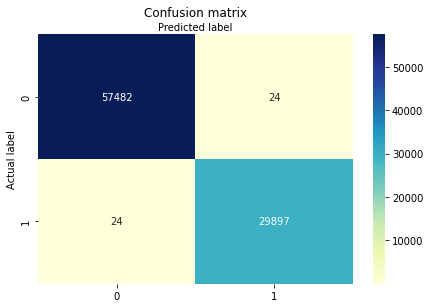

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.99945097052398
Precision: 0.9991978877711306
Recall: 0.9991978877711306


## K-Nearest Neighbor(KNN)

In [ ]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test) # Will take 7 min

**Model Evaluation**

Text(0.5, 257.44, 'Predicted label')

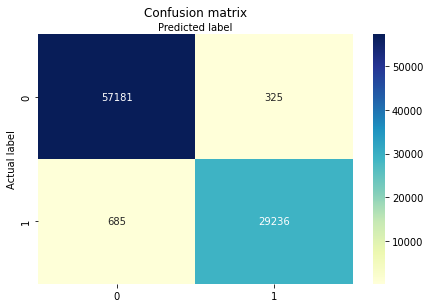

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9884475047754127
Precision: 0.9890057846486925
Recall: 0.9771063801343538
